In [57]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.utils.prune as prune

import pathlib
import copy
from collections import defaultdict
import matplotlib.pyplot as plt

from datasets import symbolic_1
from architectures.simlpe_mlp import SimpleMLP
from common import torch_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
model_shape = [symbolic_1.INPUT_DIM, symbolic_1.OUTPUT_DIM]
model = SimpleMLP(model_shape)
pruning_levels = 20
pruning_rate = .2

torch_utils.count_model_biases(model), torch_utils.count_model_weights(model)
torch_utils.count_pruned_weights(model), torch_utils.count_pruned_biases(model)
torch_utils.remaining_weights_by_pruning_steps(model, pruning_rate, pruning_levels)

[10, 8, 6, 5, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

https://discuss.pytorch.org/t/cant-reset-parameters-with-torch-nn-utils-prune/76115/4
https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#iterative-pruning

In [120]:
def check_if_state_dicts_equal(sd1, sd2, compare=None):
    """ONLY PROBLEM: When the gradients are zero, state dicts will also be unchanged."""
    equal = True
    for (k1, v1), (k2, v2) in zip(sd1.items(), sd2.items()):
        if k1 != k2:
            raise Exception("The state dicts must be the same")

        if compare is not None and compare not in k1: continue

        if not torch.equal(v1, v2):
            equal= False
            # print(f"{k1}-1 and {k2}-2 are not equal")
    # print(equal)
    return equal


In [121]:
model = SimpleMLP(weight_shape=[symbolic_1.INPUT_DIM,2,2, symbolic_1.OUTPUT_DIM])

# optimizer and loss
lr = 0.1
optim = torch.optim.SGD(model.parameters(), lr = lr)
loss_fn = torch.nn.MSELoss(reduction="mean")

# preparing for pruning
modules = [m for m in model.modules if torch_utils.module_is_trainable(m)]
parameters_to_prune = [(module, 'weight') for module in modules]

# tracking metrics
loss = defaultdict(list)
stats_dict = torch_utils.pruning_stats(parameters_to_prune)

# training
epochs = 8
train_loader, test_loader = symbolic_1.get_dataloaders()

prune.global_unstructured(
        parameters_to_prune,
        prune.L1Unstructured,
        amount=0,
    )

# deepcopy is necessary, otherwise the state_dict just holds a reference to the modules
init =  copy.deepcopy(model.state_dict())

# creates a copy
init_state_dict_no_masks = {k: v for k, v in init.items() if "_mask" not in k}

total_params = torch_utils.count_model_weights(model)
for step in range(epochs):
    print(torch_utils.measure_global_sparsity(model, use_mask=True))

    model.load_state_dict(init_state_dict_no_masks, strict=False)
    reinit = copy.deepcopy(model.state_dict())
    assert check_if_state_dicts_equal(init, reinit, compare="weight_orig") == True
    if step > 0:
        assert (check_if_state_dicts_equal(init, reinit, compare="weight_mask") == False)

    eval_loss = torch_utils.evaluate(model, test_loader, loss_fn)
    train_loss = torch_utils.update(model, train_loader, optim, loss_fn)
    trained = copy.deepcopy(model.state_dict())
    assert check_if_state_dicts_equal(trained, reinit, compare="weight_mask") == True
    assert check_if_state_dicts_equal(trained, reinit, compare="weight_orig") == False
    assert check_if_state_dicts_equal(trained, reinit, compare="bias") == False

    loss['eval'].append(eval_loss)
    loss['train'].append(train_loss)    

    prune.global_unstructured(parameters_to_prune, prune.L1Unstructured, amount=pruning_rate)
    pruned = copy.deepcopy(model.state_dict())

    assert check_if_state_dicts_equal(trained, pruned, compare="weight_orig") == True
    assert check_if_state_dicts_equal(trained, pruned, compare="weight_mask") == False

model.load_state_dict(init_state_dict_no_masks, strict=False)

(0, 16, 0.0)
(3, 16, 0.1875)
(6, 16, 0.375)
(8, 16, 0.5)
(10, 16, 0.625)


AssertionError: 

In [78]:
trained

OrderedDict([('model.0.bias', tensor([0.4994, 0.0522])),
             ('model.0.weight_orig',
              tensor([[-0.4481,  0.0984, -0.3170, -0.2402],
                      [-0.0311,  0.3378, -0.3409, -0.3065]])),
             ('model.0.weight_mask',
              tensor([[1., 1., 1., 1.],
                      [1., 1., 1., 1.]])),
             ('model.2.bias', tensor([-0.0167, -0.2209])),
             ('model.2.weight_orig',
              tensor([[ 0.3972, -0.5315],
                      [-0.4040,  0.2376]])),
             ('model.2.weight_mask',
              tensor([[1., 1.],
                      [1., 1.]])),
             ('model.4.bias', tensor([-0.6329, -0.3847])),
             ('model.4.weight_orig',
              tensor([[ 0.5343,  0.7008],
                      [-0.0871,  0.4187]])),
             ('model.4.weight_mask',
              tensor([[1., 1.],
                      [1., 1.]]))])

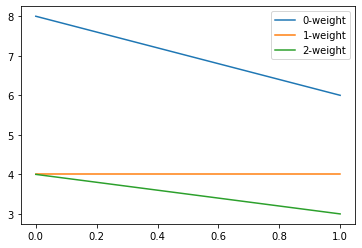

In [76]:

parameters_to_prune = [(module, 'weight') for module in modules]
stats_dict = torch_utils.pruning_stats(parameters_to_prune, stats_dict)

for k, v in stats_dict.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()

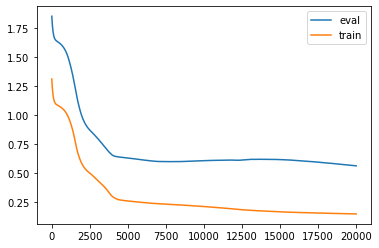

In [40]:
plt.plot(loss['eval'], label="eval")
plt.plot(loss['train'], label="train")
plt.legend()
plt.show()